# Домашнее задание
Предсказать рейтинг отеля по отзыву.

Данные лежат в train.csv - остальные файлы вспомогательные.

Половина оценки за решение, вторая половина за то, как будете генерировать фичи.

In [539]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk import wordnet, pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

## Look data

In [406]:
data = pd.read_csv("train.csv", encoding='cp1252')
data

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0


In [407]:
data.set_index('Id', inplace=True)
drop_columns = ['Hotel_name', 'Review_Title']
data.drop(drop_columns, axis=1, inplace=True)

## Sentence Segmentation

In [408]:
def sentence_segmentation(text: str) -> list:
    if re.match(r'[\.!\?;]', text[-1]):
        text = text[:-1]
    return re.split(r'[\.!\?;]\s', text.lower())

In [409]:
data['segments'] = data['Review_Text'].apply(sentence_segmentation)

## Tokenization

In [410]:
def tokenization(sentences: list) -> list:
    return [re.split(r'[,:(\s\-)]*\s', s) for s in sentences]

In [411]:
data['tokens'] = data['segments'].apply(tokenization)

## Lemmatization

In [412]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [413]:
def lemmatization(sentences: list) -> list:
    sentences_tag  = [pos_tag(s) for s in sentences] # получаем теги слов каждого предложения
    
    lemmatizer = WordNetLemmatizer()
    lemm_sentences = []
    for sent in sentences_tag:
        pos_tagged = [(word, get_wordnet_pos(tag)) for word, tag in sent]
        lemm_sentences.append([lemmatizer.lemmatize(word, tag) for word, tag in pos_tagged])

    return lemm_sentences

In [414]:
data['lemmatization'] = data['tokens'].apply(lemmatization)

## Delete stopwords

In [415]:
stop_words = set(stopwords.words('english')).union({'\r', '\t', '\n', '', ' '})

In [416]:
def del_stopwords(sentences: list) -> list:
    upd_sentences = []
    for sent in sentences:
        upd_sentences.append([word for word in sent if word not in stop_words and len(word) != 1])
    
    return upd_sentences

In [417]:
data['del_stopwords'] = data['lemmatization'].apply(del_stopwords)

## Look on steps

In [418]:
row = data.loc[34]
for col in row.keys():
    if col != 'Rating':
        print(f"{col:20} -> {row[col]}\n")

Review_Text          -> The stay was very good .....the hotel had a good location....very easy to reach over there it had a pleasent appearance..the behaviour of d people over there were very polite...the service was in time.....the food was very good...the rooms were well maintained spacious and clean

segments             -> ['the stay was very good .....the hotel had a good location....very easy to reach over there it had a pleasent appearance..the behaviour of d people over there were very polite...the service was in time.....the food was very good...the rooms were well maintained spacious and clean']

tokens               -> [['the', 'stay', 'was', 'very', 'good', '.....the', 'hotel', 'had', 'a', 'good', 'location....very', 'easy', 'to', 'reach', 'over', 'there', 'it', 'had', 'a', 'pleasent', 'appearance..the', 'behaviour', 'of', 'd', 'people', 'over', 'there', 'were', 'very', 'polite...the', 'service', 'was', 'in', 'time.....the', 'food', 'was', 'very', 'good...the', 'rooms', 'we

Мне достаточно повезло, что я выбрала 34 строку. Сразу видна ошибка. В отзывах люди ведь пишут не всегда грамматически правильно! Исправляем.

In [419]:
def clean_text(text: list) -> list:
    return re.sub(r'\W{2,}', ' ', text)

In [420]:
def union_sentences(sentences: list) -> list:
    return list(set().union(*sentences))

## Pipeline 

In [421]:
class Pipeline:
    def __init__(self, name_functions: dict):
        self.name_func = name_functions

    def transform(self, data: pd.DataFrame, name_col: str, verbose=True):
        for name, func in self.name_func.items():
            data[name_col] = data[name_col].apply(func)
            data[name] = data[name_col]
            
            if verbose:
                print(f"{name:20} complete")

In [422]:
pipeline = Pipeline({
    "clean_text": clean_text, 
    "segments": sentence_segmentation, 
    "tokens": tokenization, 
    "lemmatization": lemmatization, 
    "del_stopwords": del_stopwords,
    "union_sentences" : union_sentences})

In [423]:
pipeline.transform(data, 'Review_Text')

clean_text           complete
segments             complete
tokens               complete
lemmatization        complete
del_stopwords        complete
union_sentences      complete


## Split data

In [424]:
target = ['Rating']

In [425]:
X = data.drop(target, axis=1)
y = data[target]

In [426]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization

In [427]:
def dummy_fun(doc):
    return doc

In [428]:
tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun,token_pattern=None)

In [429]:
tfidf.fit(x_train['Review_Text'])

TfidfVectorizer(preprocessor=<function dummy_fun at 0x0000023B0CD63310>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x0000023B0CD63310>)

In [430]:
def vectorization(words: list):
    return tfidf.transform([words]).toarray().squeeze()

In [469]:
x_train['vectors'] = x_train['Review_Text'].apply(vectorization)
x_test['vectors'] = x_test['Review_Text'].apply(vectorization)

## Add count positive and negative words

Добавим колонки количества позитивных и негативных слов в отзыве

In [432]:
x_train.head()

,Review_Text,segments,tokens,lemmatization,del_stopwords,clean_text,union_sentences,vectors
Id,,,,,,,,
564,"[take, poorly, train, property, service, seem,...",[this hotel is in a fantastic location walking...,"[[this, hotel, is, in, a, fantastic, location,...","[[this, hotel, be, in, a, fantastic, location,...","[[hotel, fantastic, location, walk, distance, ...",This hotel is in a fantastic location walking ...,"[take, poorly, train, property, service, seem,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
297,"[visa, prompt, service, staff, overall, small,...",[i have visited here with my friends to get vi...,"[[i, have, visited, here, with, my, friends, t...","[[i, have, visit, here, with, my, friend, to, ...","[[visit, friend, get, visa, room, small, less,...",I have visited here with my friends to get Vis...,"[visa, prompt, service, staff, overall, small,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
932,"[reminder, water, tap, geyser, attend, suffici...",[water was dripping from the ac and our belong...,"[[water, was, dripping, from, the, ac, and, ou...","[[water, be, drip, from, the, ac, and, our, be...","[[water, drip, ac, belonging, get, wet, even, ...",Water was dripping from the AC And our belongi...,"[reminder, water, tap, geyser, attend, suffici...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
239,"[nice, every, service, fair, center, worth, ch...",[nice hotel very good service service boys are...,"[[nice, hotel, very, good, service, service, b...","[[nice, hotel, very, good, service, service, b...","[[nice, hotel, good, service, service, boy, go...",Nice hotel very good service Service boys are ...,"[nice, every, service, fair, center, worth, ch...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99,"[beautiful, hotel, reception, pool, lobby, fam...",[i had a pleasant stay with my family at this ...,"[[i, had, a, pleasant, stay, with, my, family,...","[[i, have, a, pleasant, stay, with, my, family...","[[pleasant, stay, family, hotel, lobby, recept...",I had a pleasant stay with my family at this h...,"[beautiful, hotel, reception, pool, lobby, fam...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [433]:
def words_file(file_name: str) -> set:
    with open(file_name, encoding='cp1252') as f:
        words = set()
        for word in f.readlines():
            words.add(word.rstrip())
        return words

In [434]:
positive_words = words_file('positive-words.txt')
negative_words = words_file('negative-words.txt')

In [435]:
def count_intersections(words: list, other_words: set) -> int:
    return len(set(words) & other_words)

In [436]:
count_pos = lambda x: count_intersections(x, positive_words)
count_neg = lambda x: count_intersections(x, negative_words)

In [437]:
def add_counts(x):
    x['count_pos'] = x['Review_Text'].apply(count_pos)
    x['count_neg'] = x['Review_Text'].apply(count_neg)

In [438]:
add_counts(x_train)
add_counts(x_test)

## Add levels of positives

In [439]:
# senti_words = pd.read_csv("SentiWordNet.txt", sep='\t')

In [440]:
# senti_words.set_index('Word', inplace=True)

In [441]:
# senti_words.loc['able']

In [442]:
# def add_levels(x):
#     q = 0
#     for sent in x:
#         for w in sent:
#             try:
#                 q += senti_words.loc[w]['Positive'] - senti_words.loc[w]['Negative']
#             except KeyError:
#                 pass
#     return q

In [443]:
# x_train['Level_positive'] = x_train['lemmatization'].apply(add_levels)
# x_test['Level_positive'] = x_train['lemmatization'].apply(add_levels)

Пыталась добавить уровень того, насколько отзыв хорош, но в senti_words лежат повторение слов. Пока не придумала, как это реализовать, но пусть код попытки останется.

## Baseline without vectors

In [444]:
linreg = LinearRegression()
linreg.fit(x_train[['count_pos', 'count_neg']], y_train)
y_pred = linreg.predict(x_train[['count_pos', 'count_neg']])
print(f"R2 on train set: {r2_score(y_train, y_pred)}")
print(f"MSE on train set: {mean_squared_error(y_train, y_pred)}")

R2 on train set: 0.2344148918826825
MSE on train set: 340.5700793826986


In [445]:
y_pred = linreg.predict(x_test[['count_pos', 'count_neg']])
print(f"R2 on test set:  {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set:  0.2653251351590393
MSE on train set: 329.52858624695205


## Reduce

Выбрала уменьшение размерности с помощью pca, так как фич больше, чем 2-3 и уменьшение размерности нужно не для визуализации, а для модели

In [573]:
x_train.shape

(1880, 1002)

In [478]:
pca = PCA(n_components=1000, random_state=42)
x_train['vectors'] = pca.fit_transform(np.array(x_train['vectors'].tolist())).tolist()
x_test['vectors'] = pca.transform(np.array(x_test['vectors'].tolist())).tolist()

In [ ]:
x_train.shape

## Сombining features

Теперь добавлю к векторам две новые колонки, которые я добавила выше

In [479]:
def combine(x):
    counts = np.vstack(
        (np.array(x['count_pos'].tolist()), 
         np.array(x['count_neg'].tolist()))
    )
    return np.hstack((np.array(x['vectors'].tolist()), counts.T))

In [480]:
x_train = combine(x_train)
x_test = combine(x_test)

## Baseline with vectors

In [491]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_train)
print(f"R2 on train set: {r2_score(y_train, y_pred)}")
print(f"MSE on train set: {mean_squared_error(y_train, y_pred)}")

R2 on train set: 0.8298388866214289
MSE on train set: 75.69606994276575


In [492]:
y_pred = linreg.predict(x_test)
print(f"R2 on test set:  {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set:  0.5081748254459557
MSE on train set: 220.60160515568876


Можно заметить, что векторы помогли и улучшили MSE!

## Model selection

Теперь перепробую разные модели, запишу результат в ```models_score```, чтобы далее визуализировать и выбрать лучшую

In [483]:
models_score = dict()

In [501]:
def mse_cv(reg, X, y):
    scores = -cross_val_score(reg, X, y, scoring='neg_mean_squared_error', cv=5)
    return np.mean(scores)

### Linear Regression

In [503]:
print(f"Linear Regression mse score: {mse_cv(LinearRegression(), x_train, y_train)}")

Linear Regression best score: 109120.54316229859


In [505]:
best_reg = LinearRegression()
set_params.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on train set: {mean_squared_error(y_test, y_pred)}")

R2 on train set: 0.5081748254459557
MSE on train set: 220.60160515568876


In [506]:
models_score['LinReg'] = mean_squared_error(y_test, y_pred)

### Lasso

In [508]:
param_lasso = {
    "alpha": np.arange(0.1, 3, 0.1),
    "max_iter" : np.arange(1000, 4000, 1000),
    "tol" : np.arange(0.00001, 0.0001, 0.00002)
}

In [512]:
search = GridSearchCV(
    estimator=Lasso(), 
    param_grid=param_lasso, 
    scoring='neg_mean_squared_error', 
    cv=5, n_jobs=-1
)

search.fit(x_train, y_train)

print(f"best params: {search.best_params_} \nbest MSE: {-search.best_score_}")

best params={'alpha': 0.1, 'max_iter': 1000, 'tol': 9.000000000000002e-05} best mse=300.8930782100307


In [514]:
best_reg = Lasso().set_params(**search.best_params_)
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.3651738204160072
MSE on test set: 284.7427936930334


In [515]:
models_score['Lasso'] = mean_squared_error(y_test, y_pred)

### Ridge

In [517]:
param_ridge = {
    "alpha" : np.arange(0.1, 3.0, 0.1),
    "solver": ['auto', 'svd', 'cholesky', 'sag', 'saga']
}

In [518]:
search = GridSearchCV(
    estimator=Ridge(), 
    param_grid=param_lasso, 
    scoring='neg_mean_squared_error', 
    cv=5, n_jobs=-1
)

search.fit(x_train, y_train)

print(f"best params = {search.best_params_} \nbest MSE: {-search.best_score_}")

best params={'alpha': 1.3000000000000003, 'max_iter': 1000, 'tol': 1e-05} best mse=247.80913711951501


In [519]:
best_reg = Ridge().set_params(**search.best_params_)
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.5439447535218649
MSE on test set: 204.557482247576


In [521]:
models_score['Ridge'] = mean_squared_error(y_test, y_pred)

### Decision Tree

In [523]:
param_dectree = {
    'max_depth' : np.arange(1, 20, 2),
    'min_samples_leaf' : np.arange(1, 30, 3),
    'max_features' : ['sqrt', 'log2', 'auto']
}

In [529]:
search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_dectree,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

search.fit(x_train, y_train)
print(f"best param: {search.best_params_} \nbest MSE: {-search.best_score_:,}")

best param: {'max_depth': 5, 'max_features': 100, 'min_samples_leaf': 16} 
best MSE: -323.4960161822846


In [532]:
best_reg = DecisionTreeRegressor().set_params(**search.best_params_)
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.11635747165072496
MSE on test set: 396.34603965613206


In [533]:
models_score['Decision Tree'] = mean_squared_error(y_test, y_pred)

### RandomForestRegressor

In [537]:
param_randforest = {
    'max_depth' : np.arange(1, 10, 3),
    'min_samples_leaf' : np.arange(1, 10, 3),
    'max_features' : ['sqrt', 'log2', 'auto'],
    'n_jobs' : [-1]
}

In [541]:
search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_randforest,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

search.fit(x_train, y_train)
print(f"best param: {search.best_params_} \nbest MSE: {-search.best_score_:,}")

best param: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_jobs': -1} 
best score RMSE: -252.50047453882317


In [542]:
best_reg = RandomForestRegressor(random_state=42).set_params(**search.best_params_)
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.49136121849602565
MSE on test set: 228.14312371454375


In [543]:
models_score['Random Forest'] = mean_squared_error(y_test, y_pred)

### CatBoostRegressor

In [546]:
param_catboost = {
    'learning_rate': [0.5, 1],
    'depth': [1, 2, 3],
    'l2_leaf_reg': [1, 2, 3]
}

In [548]:
search = CatBoostRegressor().grid_search(
    param_catboost,
    X=x_train, 
    y=y_train, 
    plot=True,
    verbose=False
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 42.3122086	test: 42.3784262	best: 42.3784262 (0)	total: 24.5ms	remaining: 24.5s
1:	learn: 27.9988710	test: 27.8954988	best: 27.8954988 (1)	total: 31.3ms	remaining: 15.6s
2:	learn: 21.6933140	test: 21.3393177	best: 21.3393177 (2)	total: 37.2ms	remaining: 12.4s
3:	learn: 19.2610795	test: 18.9807668	best: 18.9807668 (3)	total: 43.1ms	remaining: 10.7s
4:	learn: 18.3636177	test: 17.9499363	best: 17.9499363 (4)	total: 49.1ms	remaining: 9.77s
5:	learn: 17.8812340	test: 17.5409497	best: 17.5409497 (5)	total: 55.4ms	remaining: 9.18s
6:	learn: 17.6381302	test: 17.4338082	best: 17.4338082 (6)	total: 62.6ms	remaining: 8.88s
7:	learn: 17.5069829	test: 17.4199319	best: 17.4199319 (7)	total: 68.9ms	remaining: 8.54s
8:	learn: 17.4276221	test: 17.4260591	best: 17.4199319 (7)	total: 76.2ms	remaining: 8.39s
9:	learn: 17.2810613	test: 17.3712726	best: 17.3712726 (9)	total: 82.5ms	remaining: 8.16s
10:	learn: 17.1603227	test: 17.2854551	best: 17.2854551 (10)	total: 89.3ms	remaining: 8.03s
11:	lear

In [549]:
search['params']

{'depth': 2, 'l2_leaf_reg': 2, 'learning_rate': 0.5}

In [551]:
best_reg = CatBoostRegressor(random_state=42, silent=True).set_params(**search['params'])
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

R2 on test set: 0.5492784848168318
MSE on test set: 202.16510840008897


In [552]:
models_score['Catboost'] = mean_squared_error(y_test, y_pred)

### LightGBM

In [554]:
params_LGBM = {
    'num_leaves' : np.arange(30, 35),
    'max_depth' : np.arange(1, 4),
    'learning_rate' : [0.1, 0.3]
}

In [555]:
search = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=params_LGBM,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

search.fit(x_train, y_train)
print(f"best param: {search.best_params_} \nbest MSE: {-search.best_score_:,}")

best param: {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 30} 
best MSE: 249.82802725549612


In [557]:
best_reg = LGBMRegressor().set_params(**search.best_params_)
best_reg.fit(x_train, y_train)
y_pred = best_reg.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.5252929637735024
MSE on test set: 212.9234931197239


In [558]:
models_score['LightGBM'] = mean_squared_error(y_test, y_pred)

### XGBoost

In [563]:
regressor = XGBRegressor()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_train)
print(f"R2 on train set: {r2_score(y_train, y_pred)}")
print(f"MSE on train set: {mean_squared_error(y_train, y_pred)}")

R2 on train set: 0.9956515890959331
MSE on train set: 1.9343880008696923


In [564]:
y_pred = regressor.predict(x_test)
print(f"R2 on test set: {r2_score(y_test, y_pred)}")
print(f"MSE on test set: {mean_squared_error(y_test, y_pred)}")

R2 on test set: 0.5881072158315694
MSE on test set: 184.74900033734818


In [565]:
models_score['XGBoost'] = mean_squared_error(y_test, y_pred)

## The best model

<BarContainer object of 8 artists>

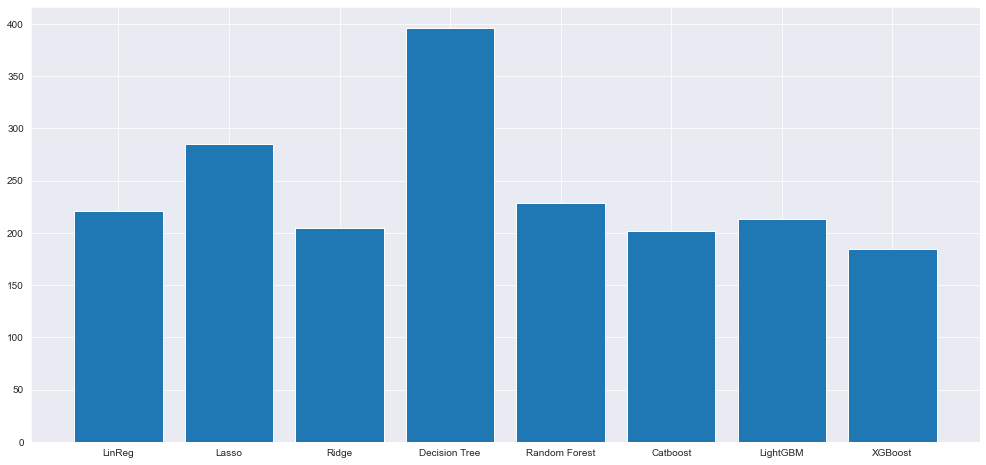

In [566]:
plt.figure(figsize=(17, 8))
plt.bar(list(models_score.keys()), list(models_score.values()))

In [574]:
sorted(models_score.items(), key=lambda x: x[1])

[('XGBoost', 184.74900033734818),
 ('Catboost', 202.16510840008897),
 ('Ridge', 204.557482247576),
 ('LightGBM', 212.9234931197239),
 ('LinReg', 220.60160515568876),
 ('Random Forest', 228.14312371454375),
 ('Lasso', 284.7427936930334),
 ('Decision Tree', 396.34603965613206)]

XGBoost оказался лучше всех, даже учитывая то, что я не перебирала фичи на нем! Хуже всех оказалось дерево решений.

## Test data

In [484]:
test_data = pd.read_csv('test.csv', encoding='cp1252')

Удаляем лишние колонки:

In [485]:
test_data.set_index('Id', inplace=True)
drop_columns = ['Hotel_name', 'Review_Title']
test_data.drop(drop_columns, axis=1, inplace=True)

Обрабатываем:

In [486]:
pipeline.transform(test_data, 'Review_Text')

clean_text           complete
segments             complete
tokens               complete
lemmatization        complete
del_stopwords        complete
union_sentences      complete


Векторизуем:

In [487]:
test_data['vectors'] = test_data['Review_Text'].apply(vectorization)
test_data['vectors'] = pca.transform(np.array(test_data['vectors'].tolist())).tolist()

Добавляем количество позитивных и отрицательных слов:

In [488]:
add_counts(test_data)

Комбинируем:

In [489]:
x_test_data = combine(test_data)

Предсказываем:

In [568]:
regressor = XGBRegressor()
regressor.fit(np.vstack((x_train, x_test)), np.vstack((y_train, y_test)))
y_pred = regressor.predict(x_test_data)

In [569]:
y_pred

array([99.894325, 76.30291 , 82.95983 , ..., 57.895355, 40.053295,
       80.03505 ], dtype=float32)

In [570]:
test_data['Rating'] = y_pred

In [571]:
test_data.head(15)

,Review_Text,clean_text,segments,tokens,lemmatization,del_stopwords,union_sentences,vectors,count_pos,count_neg,Rating
Id,,,,,,,,,,,
2351,"[bless, unnoticed, courteous, prompt, service,...",On the night of my arrival from NY I had a min...,[on the night of my arrival from ny i had a mi...,"[[on, the, night, of, my, arrival, from, ny, i...","[[on, the, night, of, my, arrival, from, ny, i...","[[night, arrival, ny, minor, problem, room, mr...","[bless, unnoticed, courteous, prompt, service,...","[-0.07633433732720485, -0.05834411744466486, -...",5,3,99.894325
2352,"[acceptable, high, wise, money, bit, great, st...",Not so great But it is still acceptable Bit hi...,[not so great but it is still acceptable bit h...,"[[not, so, great, but, it, is, still, acceptab...","[[not, so, great, but, it, be, still, acceptab...","[[great, still, acceptable, bit, high, money, ...","[acceptable, high, wise, money, bit, great, st...","[-0.06657580859874099, -0.06627147448654085, -...",2,0,76.302910
2353,"[service, park, traditional, stay, find, quite...",Been a good place to stay for people who visit...,[been a good place to stay for people who visi...,"[[been, a, good, place, to, stay, for, people,...","[[be, a, good, place, to, stay, for, people, w...","[[good, place, stay, people, visit, olympia, t...","[service, park, traditional, stay, find, quite...","[0.005201773703588089, 0.019460160995533396, 0...",3,0,82.959831
2354,"[ac.no, water.no, paid.worst, cleaning, money,...",Not worth of the money we paid.worst ac.no wat...,[not worth of the money we paid.worst ac.no wa...,"[[not, worth, of, the, money, we, paid.worst, ...","[[not, worth, of, the, money, we, paid.worst, ...","[[worth, money, paid.worst, ac.no, water.no, c...","[ac.no, water.no, paid.worst, cleaning, money,...","[-0.07384217401221116, -0.07384972422455369, 0...",1,0,62.140831
2355,"[pack, friendly, reasonable, dated, staff, qua...",A well located hotel with decent sized rooms b...,[a well located hotel with decent sized rooms ...,"[[a, well, located, hotel, with, decent, sized...","[[a, well, locate, hotel, with, decent, size, ...","[[well, locate, hotel, decent, size, room, bit...","[pack, friendly, reasonable, dated, staff, qua...","[0.011472477987614284, 0.040683527915296315, -...",7,0,82.323601
2356,"[moreover, good, clean, maintain, food, hotel,...",It was a fantastic stay in the hotel The staff...,[it was a fantastic stay in the hotel the staf...,"[[it, was, a, fantastic, stay, in, the, hotel,...","[[it, be, a, fantastic, stay, in, the, hotel, ...","[[fantastic, stay, hotel, staff, good, coopera...","[moreover, good, clean, maintain, food, hotel,...","[0.06378844193295331, 0.09133242062136006, -0....",6,0,80.921021
2357,"[every, worth, stay, room, believe, hand, penn...",It's really hard to believe that now with 3-4k...,[it's really hard to believe that now with 3-4...,"[[it's, really, hard, to, believe, that, now, ...","[[it's, really, hard, to, believe, that, now, ...","[[really, hard, believe, 3-4k, hand, easily, g...","[every, worth, stay, room, believe, hand, penn...","[-0.07392346429239764, -0.07251766074838117, -...",3,1,86.136818
2358,"[stay, tree, bit, comfortability, disappointin...",Compared to other lemon tree stay this was bit...,[compared to other lemon tree stay this was bi...,"[[compared, to, other, lemon, tree, stay, this...","[[compare, to, other, lemon, tree, stay, this,...","[[compare, lemon, tree, stay, bit, disappointi...","[stay, tree, bit, comfortability, disappointin...","[-0.06294637074342582, -0.038552688314078425, ...",0,2,38.552856
2359,"[receptionist, clean, service, etc, refer, che...",One of my close friend referred this hotel and...,[one of my close friend referred this hotel an...,"[[one, of, my, close, friend, referred, this, ...","[[one, of, my, close, friend, refer, this, hot...","[[one, close, friend, refer, hotel, book, even...","[receptionist, clean, service, etc, refer, che...","[-0.07344255560028803, -0.0619321185384217, 0....",2,

In [572]:
test_data['Rating'].to_csv("sample.csv", index=True)